In [1]:
import sys
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

1498426106769281422

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C', 'D', 'E'])

genome_creator.add_gene_specs.vectorial(name='z', length=4, replace=False, domain=['i', 'j', 'k', 'l', 'm'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C', 'D', 'E']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k', 'l', 'm'],
  'ranges': {'length': 4, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(8)
popdet

Population with 512 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.input.head()

,x,y,z
id,,,
-2311121770384920740,0,A,"(i, j, k, l)"
8121178475967757911,0,A,"(i, l, k, m)"
-424982330329757554,0,A,"(j, k, i, l)"
5302173382874556174,0,A,"(j, m, k, l)"
-9212557593147139075,0,A,"(k, l, i, j)"


In [15]:
poprand = pop_creator.create.rand(500)
poprand

Population with 500 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
-5366168046210034197,8,E,"(m, i, l, k)"
2612157645512327506,4,B,"(k, m, j, l)"
9077002637884115198,1,C,"(l, k, m, j)"
-7406983480297035617,2,E,"(j, i, m, l)"
-5878808263387039893,5,E,"(m, k, i, l)"


In [17]:
pop = popdet + poprand
pop

Population with 1012 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
pop.drop_duplicates()
pop

Population with 783 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [19]:
pop.datasets.input.head()

,x,y,z
id,,,
-2311121770384920740,0,A,"(i, j, k, l)"
8121178475967757911,0,A,"(i, l, k, m)"
-424982330329757554,0,A,"(j, k, i, l)"
5302173382874556174,0,A,"(j, m, k, l)"
-9212557593147139075,0,A,"(k, l, i, j)"


# Environment

In [20]:
from lamarck import Environment

In [21]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 73
    return {
        'time': (x + 1) * abs(zval - yval) // 10,
        'profit': (abs(3*zval - 2*yval)**((int(x/10) + 1) % 9) // (tuplehash((y, y)) % 7 + 1)) % 10000 + (zval*yval) //10
    }

In [22]:
env = Environment()

In [23]:
env.config.set_process(dummy_process)

In [24]:
env.config.set_output_varibles('time', 'profit')

In [25]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7f47cefb1a60>

In [26]:
cr = pop[10]
cr

Creature <-8733467105369308285> - genome: {'x': 0, 'y': 'B', 'z': ('j', 'k', 'i', 'l')}

### Simulate Creature

In [27]:
env.simulate(cr)

{'time': 54.0, 'profit': 3384.0}

### Simulate Population

In [28]:
simpop = pop.copy()

In [29]:
env.simulate(simpop)

In [35]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
-2311121770384920740,0,A,"(i, j, k, l)",95.0,2154.0
8121178475967757911,0,A,"(i, l, k, m)",62.0,1105.0
-424982330329757554,0,A,"(j, k, i, l)",56.0,930.0
5302173382874556174,0,A,"(j, m, k, l)",27.0,338.0
-9212557593147139075,0,A,"(k, l, i, j)",45.0,715.0


### Simulate Population - Multi Thread

In [36]:
env.config.set_multi(True)

In [37]:
env.simulate(simpop)

In [38]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
-2311121770384920740,0,A,"(i, j, k, l)",95.0,2154.0
8121178475967757911,0,A,"(i, l, k, m)",62.0,1105.0
-424982330329757554,0,A,"(j, k, i, l)",56.0,930.0
5302173382874556174,0,A,"(j, m, k, l)",27.0,338.0
-9212557593147139075,0,A,"(k, l, i, j)",45.0,715.0


# Fitness

### 1. Single Objective

In [40]:
single_objective_pop = simpop.copy()
single_objective_pop.apply_fitness.single_objective(output='time', objective='min')

In [41]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
id,,,,,,
-7418012264280342711,5,C,"(m, i, l, j)",0.0,26.0,0.0
9077002637884115198,1,C,"(l, k, m, j)",0.0,27.0,0.0
8783385848233624038,9,B,"(j, i, m, l)",0.0,65.0,0.0
5688944865713323924,2,E,"(m, i, j, k)",0.0,227.0,0.0
-6553138373434287334,0,B,"(l, k, m, j)",0.0,91.0,0.0


### 2. Multi Objective - Ranked

In [42]:
ranked_objective_pop = simpop.copy()
ranked_objective_pop.apply_fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [43]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
id,,,,,,,
5688944865713323924,2,E,"(m, i, j, k)",0.0,227.0,0.0,227.0
5708894731771342730,2,E,"(l, k, m, i)",0.0,218.0,0.0,218.0
-6553138373434287334,0,B,"(l, k, m, j)",0.0,91.0,0.0,91.0
-4010107794088262724,9,B,"(i, m, j, l)",0.0,70.0,0.0,70.0
8783385848233624038,9,B,"(j, i, m, l)",0.0,65.0,0.0,65.0


### 3. Multi Objective - Pareto

In [44]:
pareto_objective_pop = simpop.copy()
pareto_objective_pop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [45]:
pareto_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
2941931596413198285,10,E,"(i, l, k, m)",64.0,10444.0,-0.034458,6.752109,1,inf
-4212862584898279532,0,A,"(j, l, i, m)",0.0,9.0,-1.510947,-0.676142,1,inf
-2206211520026585127,10,B,"(l, m, i, j)",13.0,3417.0,-1.211036,1.749874,1,4.734635
-8198866316848277721,10,B,"(l, i, k, m)",22.0,7089.0,-1.003404,4.363821,1,4.239341
-9159174176909665451,10,B,"(j, m, k, l)",26.0,8951.0,-0.911124,5.689303,1,3.357234


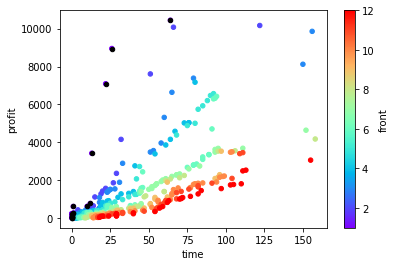

In [47]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1)

# Selection

In [48]:
selected_pop = pareto_objective_pop.select()

In [49]:
selected_pop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
2941931596413198285,10,E,"(i, l, k, m)",64.0,10444.0,-0.034458,6.752109,1,inf
-4212862584898279532,0,A,"(j, l, i, m)",0.0,9.0,-1.510947,-0.676142,1,inf
-2206211520026585127,10,B,"(l, m, i, j)",13.0,3417.0,-1.211036,1.749874,1,4.734635
-8198866316848277721,10,B,"(l, i, k, m)",22.0,7089.0,-1.003404,4.363821,1,4.239341
-9159174176909665451,10,B,"(j, m, k, l)",26.0,8951.0,-0.911124,5.689303,1,3.357234
...,...,...,...,...,...,...,...,...,...
-2529234069696293676,9,D,"(l, m, i, j)",19.0,73.0,-1.072615,-0.630583,12,0.061511
-6991487901554725359,4,E,"(i, l, k, m)",71.0,1035.0,0.127033,0.054226,12,0.061511
1611663322079526276,1,D,"(i, l, k, m)",71.0,1022.0,0.127033,0.044972,12,0.050833


# Repopulate

In [120]:
import numpy as np
import pandas as pd

In [114]:
min(np.random.choice(100, 3, replace=False))

50

In [116]:
a = pop.get_creature.from_index(0)

In [119]:
pop.datasets.input.head()

,x,y,z
id,,,
6861546195533386093,0,A,"(i, j, k, l)"
-4032542161395495972,0,A,"(i, l, k, m)"
80855953509368739,0,A,"(j, k, i, l)"
-5359771979190105310,0,A,"(j, m, k, l)"
-371711285419199414,0,A,"(k, l, i, j)"


In [118]:
a.genome

{'x': 0, 'y': 'A', 'z': ('i', 'j', 'k', 'l')}

In [125]:
pd.DataFrame({k: [v] for k, v in a.genome.items()}, index=[a.id])

,x,y,z
6861546195533386093,0,A,"(i, j, k, l)"


## Mutation